# Aufgabe für die Projektgruppe 2

Bearbeiten Sie die folgende Aufgabe:

Ihr Auftraggeber ist eine Familie, welche eine Beratung von Ihnen benötigt. Sie besitzt ein kleines altes Windrad, welches nur für den Eigenverbrauch genutzt wird sowie eine PV Anlage. Die Familie möchte von Ihnen wissen, ob Sie Kosten durch die Investition in verschiedene Komponenten ihres Energiesystems einsparen kann. 

Nehmen Sie dabei die folgenden Angaben an:
* Nennleistung der Windernergieanlage: 5 kW (Keine EEG- Vergütung)
* Nennleistung der PV-Anlage 9 kWp (70% Kappungsgrenze berücksichtigen)
* Die Anschlussleistung an das elektrische Netz beträgt 15 kW
* Die Heizleistung des Erdgaskessel liegt bei 20 kW, der Wirkungsgrad ist 99%
* Erdgaspreis: 7 cent/kWh
* Strompreis: 30 cent/kWh
* EEG-Vergütung PV Anlage: 12,30 cent/kWh

Prüfen und kombinieren Sie mindestens drei der unten aufgeführten Optionen und bewerten Sie diese nach ihrer wirtschaftlicher Vorteilhaftigkeit. Unter den gewählten Optionen sollte sich mindestens eine der beiden Optionen BHKW oder Wärmepumpe befinden:
- Implementierung eines Heizstabes mit annuitätische Kosten von 50€ (Elektrische Leistung 5 kW, Wirkungsgrad 98%) 
- Installation eines BHKWs mit annuitätische Kosten von 1.200€ (Elektrische Leistung 1kW, elektrischer Wirkungsgrad 16%, Thermischer Wirkungsgrad 80%, nehmen Sie eine feste Stromkennzahl von 0,2 an, ein Beispiel für die Implementierung eines BHKWs in PyPSA finden Sie hier: https://pypsa.org/examples/chp-fixed-heat-power-ratio.html. Eine KWK-Vergütung müssen Sie nicht implementieren, da hier die pauschalierte Zuschlagzahlung gewählt wird.)
- Beschaffung einer elektrischen Batterie mit annuitätische Kosten von 900€ (8kWh Kapazität, 2,4 kW Speicher und Ladeleistung, einem Gesamtwirkungsgrad von 85%, keine Selbstentladungsverluste) 
- Erweiterung des Heizungssystems um einen thermischen Speicher mit annuitätische Kosten von 100€ (7kWh Kapazität und eine Ein und Ausspeicherleistung von 12 kW, keine Selbstentladungsverluste)
- Implementierung einer selbst gewählten Wärmepumpe. Hier müssen Sie nach geeigneten Daten zu Leistungen, Kosten und Performance recherchieren. Sie dürfen dabei die Jahresarbeitszahl als konstanten COP annehmen. Gehen Sie weiter davon aus, dass der Annuitätenfaktor für eine solche Investition bei 0,117 liegt.

1) Formulieren Sie die Optimierungsaufgabe
2) Skizzieren Sie das heutige System und bestimmen Sie die Kosten.
3) Skizzieren Sie mögliche Erweiterungen und bestimmen Sie die Kosten.
4) Interpretieren Sie die ihre Ergebnisse und ziehen Sie Schlussfolgerungen.
5) Bestimmen Sie die Grenzen Ihrer Modellierung und begründen Sie, ob die Ergebnisse trotz der Beschränkungen valide sind.

Der Import der Lastzeitreihen und der Einspeisezeitreihen ist unten schon vorbereitet. Diese repräsentieren das Jahr 2018 in stündlicher Auflösung. Nutzen Sie das in der Übung besprochene JupyterNotebook und schauen Sie sich die Funktionen und den Code dort an, um Ihr Energiesystem aufzubauen, es zu simulieren und auszuwerten.  

* [Auswärtungsfunktion](#chapter1)
    * [Import der benötigten Python Module](#section_1_1)
    * [Import der Daten](#section_1_2)
* [Bereits vorhandenes Energiesystem des Auftraggebers](#chapter2)
* [Optionen zur Erweiterung des Energiesystems](#chapter3)
    * [Definition der Variablen](#section_3_1)
    * [Energiemodell Option 1 (Heizstab)](#section_3_2)
    * [Energiemodell Option 2 (Wärmepumpe)](#section_3_3)
    * [Energiemodell Option 3 (Thermischer Speicher)](#section_3_4)
    * [Energiemodell Kombination 1 (Heizstab + Wärmepumpe)](#section_3_5)
    * [Energiemodell Kombination 2 (Heizstab + Thermischer Speicher)](#section_3_6)
    * [Energiemodell Kombination 3 (Thermischer Speicher + Wärmepumpe)](#section_3_7)
    * [Energiemodell Kombination 4 (Heizstab + Wärmepumpe + Thermischer Speicher)](#section_3_8)
* [Vergleich der Optionen und Kombinationen](#chapter4) 
* [Grenzen der Modellierung](#chapter5)    


# Optimierungsaufgabe 

Minimierung der **Gesamtkosten** durch Investition in weitere Komponenten im Energiesystem

# Auswärtungsfunktion <a class="anchor" id="chapter1"></a>

In [1]:
#Auswertung der Kosten und Anteile
def cost_share_evaluation(network):
    '''
    This function evaluate the solved PyPSA network to get the costs, revenues and the share of the selfconsumption.
    
    Parameters
    ----------
    network:            PyPSA Network
                        The solved PyPSA network with all corresponding devices
    Returns
    -------
    results :           dict
                        The dictionary with all the results.
    '''
    
    grid_import = (network.generators_t.p['grid_import'] * network.snapshot_weightings).sum()
    grid_export = (network.generators_t.p['grid_export'] * network.snapshot_weightings).sum()
    self_consumed_pv = (network.generators_t.p['pv'] * network.snapshot_weightings).sum()- grid_export
    self_consumed_wind = (network.generators_t.p['wind'] * network.snapshot_weightings).sum()
    self_consumption_ratio = (self_consumed_pv + self_consumed_wind)/(grid_import + self_consumed_pv + self_consumed_wind)
    
    electricity_cost = grid_import * network.generators.marginal_cost['grid_import']
    electricity_revenues = grid_export * network.generators.marginal_cost['grid_export']
    gas_costs = (network.generators_t.p['boiler']*network.snapshot_weightings).sum() * network.generators.marginal_cost['boiler']
    
    curtailment = ((network.generators_t.p_max_pu['pv']*network.generators.p_nom['pv'] - network.generators_t.p['pv'])*network.snapshot_weightings).sum()

    results = {"Eigenverbrauchsanteil": self_consumption_ratio,
              "Stromkosten": electricity_cost,
              "Gaskosten": gas_costs,
              "Stromerlöse": -electricity_revenues,
              "Gesamtkosten": electricity_cost + gas_costs + electricity_revenues,
              "Nicht nutzbare Energie": curtailment}
    results_energy = {'Abregelung': curtailment,
                      'Netzeinspeisung': grid_export,
                      'Eigenverbrauch': self_consumed_pv + self_consumed_wind,
                      'Netzbezug': -grid_import}
                      
    return results, results_energy

# Import der benötigten Python Module <a class="anchor" id="section_1_1"></a>

In [2]:
import pypsa
import pandas as pd
import math
import numpy as np

## Import der Daten <a class="anchor" id="section_1_2"></a>

Die Werte der Zeitreihen sind in einem Unterordner "data" als csv-Datein abgelegt. Sie bilden das Jahr 2019 ab und werden mithilfe des Python Moduls pandas eingelesen und als Variablen angelegt. Dabei werden Parameter wie der Separator (hier ";") und die Indexspalte sowie die Funktion, aus der Indexspalte Zeit und Datenformate auszulesen gesetzt.

In [3]:
pv_infeed = pd.read_csv('./data/pv_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)
wind_infeed = pd.read_csv('./data/wind_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)

In [4]:
electrical_load = pd.read_csv('./data/SumProfiles_3600s.Electricity.csv', sep = ';', index_col='time', parse_dates=True)
thermal_load = pd.read_csv('./data/SumProfiles_3600s.Gas.csv', sep = ';', index_col='time', parse_dates=True)

Die eingelesenen Zeitreihen sind so noch nicht vollständig nutzbar. Um die Einspeisung der Wind und PV-Anlage zu normieren wird eine neue Spalte mit dem normierten Leistungsoutput sowie neue Spalten mit der Leistung der Last in den jeweiligen Variablen angelegt.

In [5]:
#Die gemessenen Einspeiseganglinie ist von einer Anlage mit einer Leistung von 9 kWp, die der Windenergieanlage mit 5 kW.
pv_infeed['p_max_pu'] = pv_infeed.electricity/9 
wind_infeed['p_max_pu'] = wind_infeed.electricity/5 

Um einen kurzen Einblick in die Daten zu erhalten, schauen wir uns alle vier Tabellen an:

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

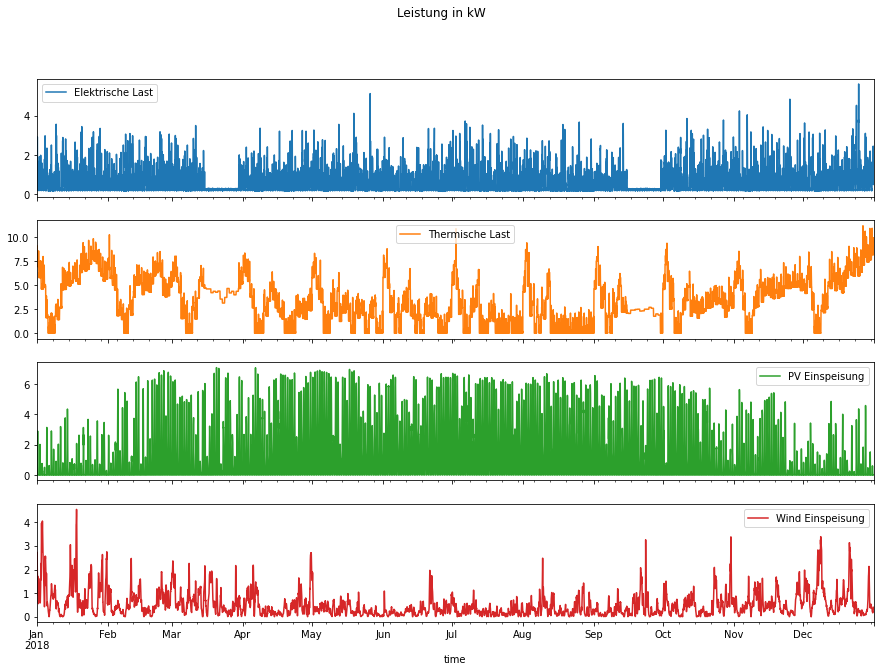

In [6]:
df_figure = pd.concat([electrical_load.sum_kwh, thermal_load.sum_kwh, pv_infeed.electricity,wind_infeed.electricity], axis = 1)
df_figure.columns = ['Elektrische Last', 'Thermische Last', 'PV Einspeisung', 'Wind Einspeisung']
df_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = True, figsize=(15,10), title= 'Leistung in kW')

In [7]:
#Strom- und Gasprofil sind in kwh pro 60 Minuten, daher Umrechnung in Leistung
electrical_load['power_kw'] = electrical_load.sum_kwh * (60.0/60.0)
thermal_load['power_kw'] = thermal_load.sum_kwh * (60.0/60.0)

# Bereits vorhandenes Energiesystem des Auftraggebers <a class="anchor" id="chapter2"></a>

### Definition der Variablen

In [8]:
# Wind-Anlage
wind = {"electrical_power": 5.0} # Nennleistung Wind

# PV-Anlage
pv = {"electrical_power": 9.0} # Nennleistung PV-Anlage

# Leistungsbezug aus dem Netz
grid_import = {"electrical_power" : 15, # Anschlussleistung an das elektrische Netz in kW
                "electricity_price": 30.0} # Strompreis in cent/kWh

# Leistungsabgabe in das Netz
grid_export = {"electrical_power" : 0.7 * pv["electrical_power"], # 70% Kappungsgrenze bei kleinen PV-Anlagen
                "electricity_revenue": 12.3} # EEG-Erlöse in cent/kWh

# Heizkessel
heating_boiler = {"thermal_power": 20.0, # 20 kW
                   "efficiency":0.99, # Effizienz als normierte Kennzahl
                   "gas_price": 7.0} # Gaspreis in cent/kWh

### Energiemodell in PyPSA

### Skizze
<img src="Skizzen der Energiesysteme/Skizze des Systems_Basis.png">

In [9]:
#Netzwerk definieren
network = pypsa.Network()
network.set_snapshots(pv_infeed.index)
network.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt reprensentiert 1 Stunde.

#Knoten definieren
network.add("Bus", name = "electricity")
network.add("Bus", name = "electricity_help")
network.add("Bus", name = "thermal")

#Lasten definieren
network.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)
network.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

#Erzeuger definieren
network.add("Generator", 
            name = "pv",
            bus = "electricity_help", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
network.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
network.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], 
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_price"]/heating_boiler["efficiency"])

#Netzanschluss definieren
network.add("Generator", 
            name = "grid_import",
            bus = "electricity_help", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
network.add("Generator", 
            name = "grid_export",
            bus = "electricity_help", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Negative Kosten = Erlöse
            sign = -1) # Vorzeichen -1 bedeutet, dass Generator Leistung aufnimmt und nicht abgibt.

#Link definieren
network.add("Link", 
            name = "link_electricity", 
            bus0 = "electricity_help", 
            bus1 = "electricity",
            p_nom = grid_import["electrical_power"] + pv["electrical_power"])

### Simulation

In [10]:
# Simulation der Basiskonfiguration für den kompletten Zeitraum:
#network.lopf()
network.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.74s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e+05


('ok', 'optimal')

In [11]:
results_base, results_energy_base  = cost_share_evaluation(network)

#Die Werte sollen auch als Text ausgegeben werden
print("Der Eigenverbrauchsanteil (Wind + PV) am Stromverbrauch in der Basiskonfiguration beträgt "
      + str(round(results_base["Eigenverbrauchsanteil"]*100,2))
      +"%. Dabei entstehen Stromkosten von "
      +str(round(results_base["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_base["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_base["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_base["Nicht nutzbare Energie"]/100,1))+ "kWh PV-Strom abgeregelt werden muss."
      +" Die Gesamtkosten betragen "+ str(round(results_base["Gesamtkosten"]/100,2)) +"€."
     )

a_0=round(results_base["Eigenverbrauchsanteil"]*100,2)
b_0=round(results_base["Gesamtkosten"]/100,2)
c_0=0.0 #Veringerrung der Gesamtkosten verglichen zur Basiskonfiguration = 0, weil dies die Basiskonfiguration ist.
d_0=0.0 #Keine Annuitätskosten

Der Eigenverbrauchsanteil (Wind + PV) am Stromverbrauch in der Basiskonfiguration beträgt 68.98%. Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1891.83€ und EEG-Erlöse von 1226.25, wobei 0.3kWh PV-Strom abgeregelt werden muss. Die Gesamtkosten betragen 1137.17€.


<AxesSubplot:xlabel='time', ylabel='Leistung in kW'>

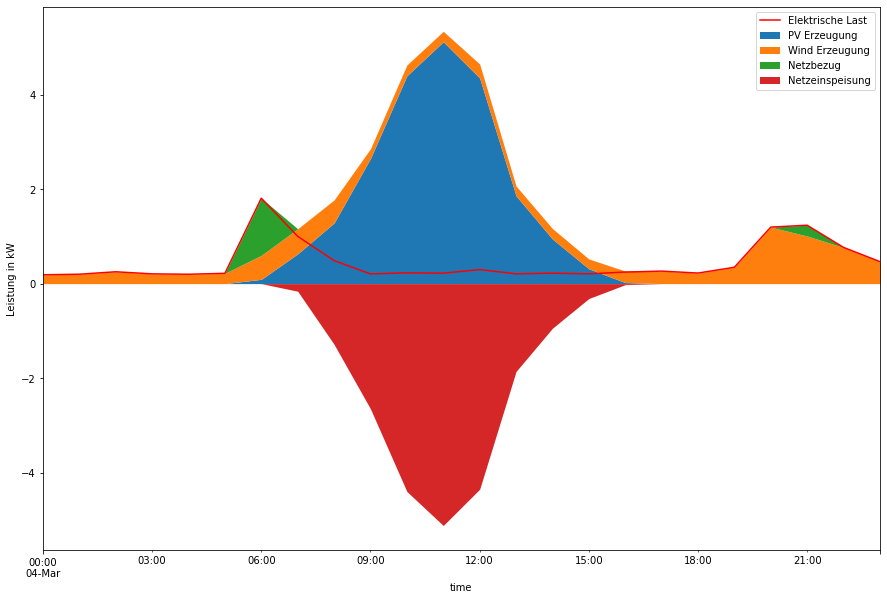

In [12]:
start_time='03-04-18 00:00:00'
end_time='03-04-18 23:00:00'
y='Leistung in kW'
x='Datum'

load_figure = network.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc[start_time:end_time].plot(legend = True, color = 'red')
ax.set_xlabel(x)
ax.set_ylabel(y)
df_figure_base = pd.concat([network.generators_t.p['pv'], network.generators_t.p['wind'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc[start_time:end_time].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)
#print(load_figure.loc[start_time:end_time])
#print(df_figure_base.loc[start_time:end_time])

# Optionen zur Erweiterung des Energiesystems <a class="anchor" id="chapter3"></a>

### Definition der Variablen <a class="anchor" id="section_3_1"></a>

In [13]:
# Heizstab
heating_rod = {"electrical_power": 5.0, # Nennleistung
              "efficiency": 0.98, # Wirkungsgrad
              "annuity_cost": 50.0} # Annuitätische Kosten 50€

# Wärmepumpe
heat_pump = {"power": 2.9, # Leistung in kW
            "COP": 4, # Coefficient of Performance
            "invest_cost": 10349.0, # Investitionskosten in €
            "annuity_factor": 0.117} # Annuitätenfaktor
heat_pump_annuity_cost = heat_pump["invest_cost"] * heat_pump["annuity_factor"]

# Thermischer Speicher
storage_thermal = {"capacity": 7.0, # Kapazität
                    "power": 12, # Lade- und Entladeleistung in kW
                    "annuity_cost": 100.0, # Annuitätische Kosten in €
                    "self-discharge": 0.0} # Keine Selbstentladungsverluste



#----------------------------------------------------------------------------------------#
# BHKW
CHP = {"electrical_power": 1.0, # Nennleistung
      "electrical_efficiency": 0.16, # Elektrischer Wirkungsgrad
      "thermal_efficiency": 0.8, # Thermischer Wirkungsgrad
      "power_heat_ratio": 0.2, # Stromkennzahl
      "annuity_cost": 1200.0} #Annuitätische Kosten 1200€

# Elektrische Batterie
storage_electrical = {"capacity": 8.0, # Kapazität
                     "power": 2.4, # Lade- und Entladeleistung in kW
                     "efficiency": 0.85, # Gesamtwirkungsgrad
                     "annuity_cost": 900.0, # Annuitätische Kosten in €
                     "self-discharge": 0.0} # Keine Selbstentladungsverluste

Quelle Daten Wärmepumpe: https://www.viessmann.de/de/wohngebaeude/waermepumpe/vitocal.html

Quelle Preis Wärmepumpe: https://www.heizungsdiscount24.de/waermepumpen/viessmann-vitocal-350-a-luftwasser-waermepumpe-127-kw-awhi-351a10-innen.html

## Energiemodell Option 1 (Heizstab) <a class="anchor" id="section_3_2"></a>

### Skizze
<img src="Skizzen der Energiesysteme/Skizze des Systems_HS.png">

In [14]:
#Netzwerk definieren
network_1 = pypsa.Network()
network_1.set_snapshots(pv_infeed.index)
network_1.snapshot_weightings = pd.Series(data = 1, index = network_1.snapshots) #Jeder Zeitpunkt reprensentiert 1 Stunde.

#Knoten definieren
network_1.add("Bus", name = "electricity")
network_1.add("Bus", name = "electricity_help")
network_1.add("Bus", name = "thermal")

#Lasten definieren
network_1.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)
network_1.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

#Erzeuger definieren
network_1.add("Generator", 
            name = "pv",
            bus = "electricity_help", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
network_1.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
network_1.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], 
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_price"] / heating_boiler["efficiency"])

#Netzanschluss definieren
network_1.add("Generator", 
            name = "grid_import",
            bus = "electricity_help", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
network_1.add("Generator", 
            name = "grid_export",
            bus = "electricity_help", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Negative Kosten = Erlöse
            sign = -1) # Vorzeichen -1 bedeutet, dass Generator Leistung aufnimmt und nicht abgibt.

#Link definieren
network_1.add("Link", 
            name = "link_electricity", 
            bus0 = "electricity_help", 
            bus1 = "electricity",
            p_nom = grid_import["electrical_power"] + pv["electrical_power"])

#--------------------------------------------------------------------------

#Heizstab definieren
network_1.add("Link",
             name = "heating_rod",
             bus0 = "electricity",
             bus1 = "thermal",
             p_nom = heating_rod["electrical_power"],
             efficiency = heating_rod["efficiency"])

In [15]:
# Simulation für den kompletten Zeitraum:
network_1.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.64s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+05


('ok', 'optimal')

In [16]:
# Ausführung der Auswertungsfunktion
results_with_modification, results_energy_with_modification = cost_share_evaluation(network_1)

Gesamtkosten=results_with_modification["Gesamtkosten"]+heating_rod["annuity_cost"]*100

print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_with_modification["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_with_modification["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_with_modification["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_with_modification["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_modification["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round((Gesamtkosten)/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_with_modification["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2))
      +"€."
     )
a_1=round(results_with_modification["Eigenverbrauchsanteil"]*100,2)
b_1=round((Gesamtkosten)/100,2)
c_1=round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2)
d_1=heating_rod["annuity_cost"]

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 77.05%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1768.41€ und EEG-Erlöse von 1226.25, wobei 0.1kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 1063.75€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 8.07 Prozentpunkte und eine Verringerung der Kosten um 73.42€.


<AxesSubplot:xlabel='time', ylabel='Leistung in kW'>

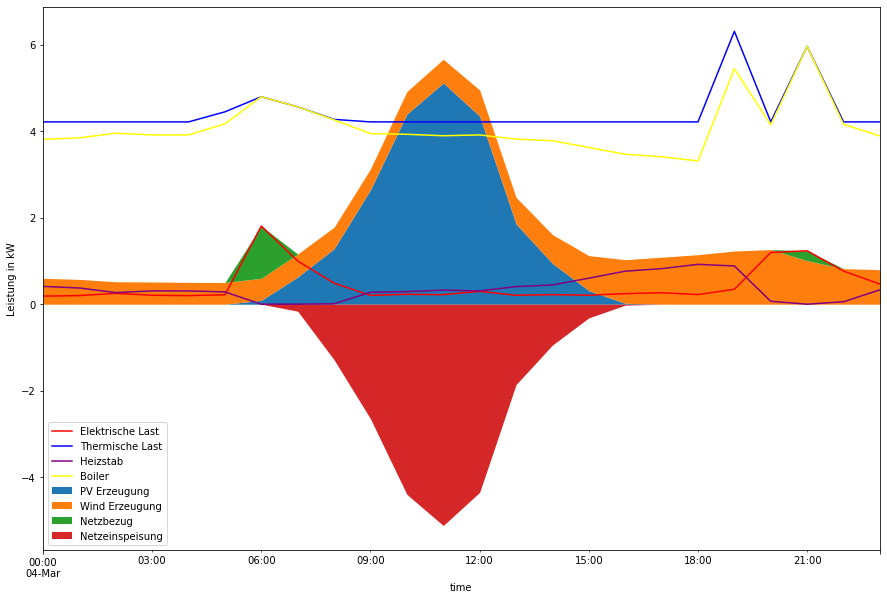

In [17]:
start_time='03-04-18 00:00:00'
end_time='03-04-18 23:00:00'
y='Leistung in kW'
x='Datum'

load_figure = pd.concat([network.loads_t.p_set['electricity_load'], network.loads_t.p_set['thermal_load'], network_1.links_t.p0['heating_rod'], network_1.generators_t.p['boiler']], axis = 1)
load_figure.columns = ['Elektrische Last','Thermische Last','Heizstab','Boiler']
ax = load_figure.loc[start_time:end_time].plot(color = ['red','blue','purple','yellow'], legend = True, stacked = False)
ax.set_xlabel(x)
ax.set_ylabel(y)
df_figure_base = pd.concat([network_1.generators_t.p['pv'], network_1.generators_t.p['wind'], network_1.generators_t.p['grid_import'], -network_1.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc[start_time:end_time].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)
#print(load_figure.loc[start_time:end_time])
#print(df_figure_base.loc[start_time:end_time])

### Interpretation & Schlussfolgerung (HS)

- Die Gesamtkosten verringern sich um 73,42€ , da kostenloser EE-Strom, anstatt Gas für den Boiler, zum Heizen verwendet wird
- Der Eigenverbrauch erhöht sich um 8,07 Prozentpunkte, da der eigen erzeugte Strom (vorwiegend durch Wind und teilweise durch PV) auch im Wärmesektor verwendet wird

&rarr; Option Heizstab sinnvoll, da geringere jährliche Gesamtkosten zu erwarten sind

## Energiemodell Option 2 (Wärmepumpe) <a class="anchor" id="section_3_3"></a>

### Skizze
<img src="Skizzen der Energiesysteme/Skizze des Systems_WP.png">

In [18]:
#Netzwerk definieren
network_2 = pypsa.Network()
network_2.set_snapshots(pv_infeed.index)
network_2.snapshot_weightings = pd.Series(data = 1, index = network_2.snapshots) #Jeder Zeitpunkt reprensentiert 1 Stunde.

#Knoten definieren
network_2.add("Bus", name = "electricity")
network_2.add("Bus", name = "electricity_help")
network_2.add("Bus", name = "thermal")

#Lasten definieren
network_2.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)
network_2.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

#Erzeuger definieren
network_2.add("Generator", 
            name = "pv",
            bus = "electricity_help", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
network_2.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
network_2.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], 
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_price"] / heating_boiler["efficiency"])

#Netzanschluss definieren
network_2.add("Generator", 
            name = "grid_import",
            bus = "electricity_help", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
network_2.add("Generator", 
            name = "grid_export",
            bus = "electricity_help", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Negative Kosten = Erlöse
            sign = -1) # Vorzeichen -1 bedeutet, dass Generator Leistung aufnimmt und nicht abgibt.

#Link definieren
network_2.add("Link", 
            name = "link_electricity", 
            bus0 = "electricity_help", 
            bus1 = "electricity",
            p_nom = grid_import["electrical_power"] + pv["electrical_power"])

#--------------------------------------------------------------------------

#Wärmepumpe definieren
network_2.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=heat_pump["power"],
            efficiency = heat_pump["COP"])

In [19]:
# Simulation für den kompletten Zeitraum:
network_2.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.67s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.84e+04


('ok', 'optimal')

In [20]:
# Ausführung der Auswertungsfunktion
results_with_modification, results_energy_with_modification = cost_share_evaluation(network_2)

Gesamtkosten=results_with_modification["Gesamtkosten"]+heat_pump_annuity_cost*100

print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_with_modification["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_with_modification["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_with_modification["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_with_modification["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_modification["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round((Gesamtkosten)/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_with_modification["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2))
      +"€."
     )
a_2=round(results_with_modification["Eigenverbrauchsanteil"]*100,2)
b_2=round((Gesamtkosten)/100,2)
c_2=round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2)
d_2=heat_pump_annuity_cost

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 80.45%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1051.16€ und EEG-Erlöse von 1039.19, wobei 0.1kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 1694.39€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 11.47 Prozentpunkte und eine Verringerung der Kosten um -557.22€.


<AxesSubplot:xlabel='time', ylabel='Leistung in kW'>

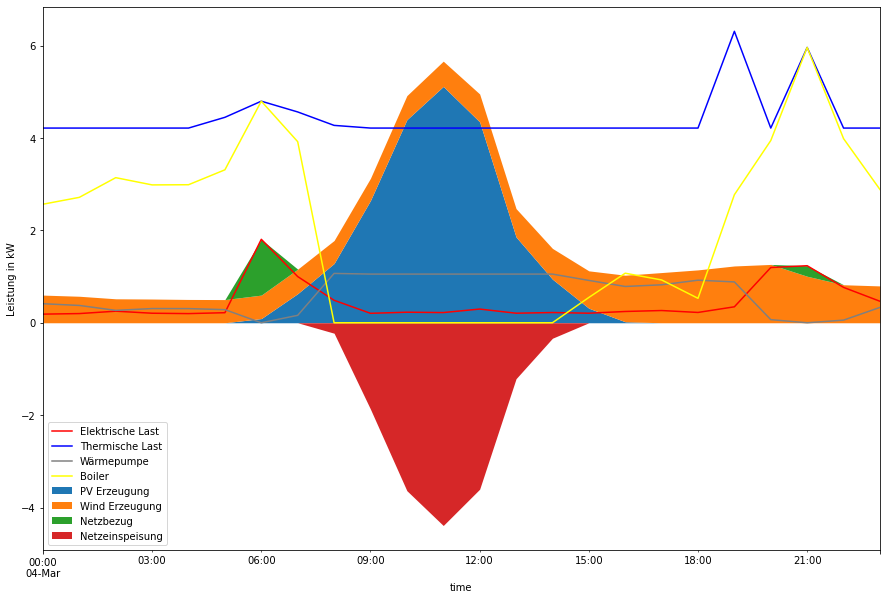

In [21]:
start_time='03-04-18 00:00:00'
end_time='03-04-18 23:00:00'
y='Leistung in kW'
x='Datum'

load_figure = pd.concat([network.loads_t.p_set['electricity_load'], network.loads_t.p_set['thermal_load'], network_2.links_t.p0['heat_pump'], network_2.generators_t.p['boiler']], axis = 1)
load_figure.columns = ['Elektrische Last','Thermische Last', 'Wärmepumpe','Boiler']
ax = load_figure.loc[start_time:end_time].plot(color = ['red','blue','grey','yellow'], legend = True, stacked = False)
ax.set_xlabel(x)
ax.set_ylabel(y)
df_figure_base = pd.concat([network_2.generators_t.p['pv'], network_2.generators_t.p['wind'], network_2.generators_t.p['grid_import'], -network_2.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc[start_time:end_time].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)
#print(load_figure.loc[start_time:end_time])
#print(df_figure_base.loc[start_time:end_time])

### Interpretation & Schlussfolgerung (WP)

- Durch die Wärmepumpe wird der Boiler vorallem in den Mittagsstunden, bei hoher Leistung der PV-Anlage, nicht betrieben, wodurch Gaskosten gespart werden.
- Der Eigenverbrauch wird um etwa 11 % erhöht 
- Die Gesamtkosten steigen jedoch um ca. 557 €, da die annuitätischen Kosten die Ersparnisse übersteigen

&rarr; Option Wärmepumpe nicht sinnvoll, da höhere jährliche Gesamtkosten zu erwarten sind

## Energiemodell Option 3 (Thermischer Speicher) <a class="anchor" id="section_3_4"></a>

### Skizze
<img src="Skizzen der Energiesysteme/Skizze des Systems_TS.png">

In [22]:
#Netzwerk definieren
network_3 = pypsa.Network()
network_3.set_snapshots(pv_infeed.index)
network_3.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt reprensentiert 1 Stunde.

#Knoten definieren
network_3.add("Bus", name = "electricity")
network_3.add("Bus", name = "electricity_help")
network_3.add("Bus", name = "thermal")

#Lasten definieren
network_3.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)
network_3.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

#Erzeuger definieren
network_3.add("Generator", 
            name = "pv",
            bus = "electricity_help", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
network_3.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
network_3.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], 
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_price"] / heating_boiler["efficiency"])

#Netzanschluss definieren
network_3.add("Generator", 
            name = "grid_import",
            bus = "electricity_help", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
network_3.add("Generator", 
            name = "grid_export",
            bus = "electricity_help", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Negative Kosten = Erlöse
            sign = -1) # Vorzeichen -1 bedeutet, dass Generator Leistung aufnimmt und nicht abgibt.

#Link definieren
network_3.add("Link", 
            name = "link_electricity", 
            bus0 = "electricity_help", 
            bus1 = "electricity",
            p_nom = grid_import["electrical_power"] + pv["electrical_power"])

#--------------------------------------------------------------------------

#Thermischen Speicher definieren
network_3.add("Bus", name = "storage_thermal")
network_3.add("Link", #Einspeichern
            name = "thermal_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = storage_thermal["power"])
network_3.add("Link", #Ausspeichern
            name = "thermal_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = storage_thermal["power"])
network_3.add("Store", 
            name = "storage_thermal", 
            bus = "storage_thermal", 
            e_nom = storage_thermal["capacity"],
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            standing_loss = storage_thermal["self-discharge"])

In [23]:
# Simulation für den kompletten Zeitraum:
network_3.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.96s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e+05


('ok', 'optimal')

In [24]:
# Ausführung der Auswertungsfunktion
results_with_modification, results_energy_with_modification = cost_share_evaluation(network_3)

Gesamtkosten=results_with_modification["Gesamtkosten"]+storage_thermal["annuity_cost"]*100

print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_with_modification["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_with_modification["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_with_modification["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_with_modification["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_modification["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round((Gesamtkosten)/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_with_modification["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2))
      +"€."
     )
a_3=round(results_with_modification["Eigenverbrauchsanteil"]*100,2)
b_3=round((Gesamtkosten)/100,2)
c_3=round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2)
d_3=storage_thermal["annuity_cost"]

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 68.98%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1891.83€ und EEG-Erlöse von 1226.25, wobei 0.3kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 1237.17€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 0.0 Prozentpunkte und eine Verringerung der Kosten um -100.0€.


<AxesSubplot:xlabel='time', ylabel='Leistung in kW'>

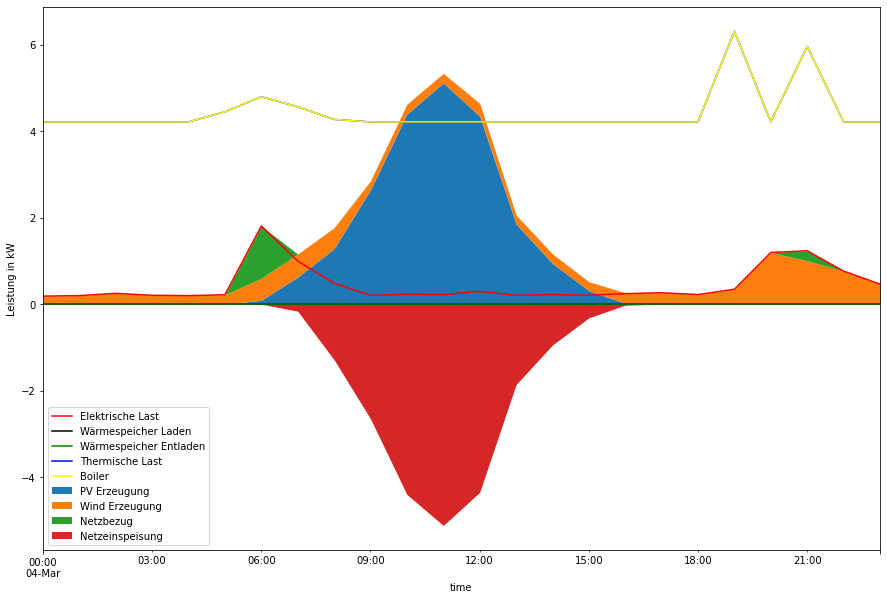

In [25]:
start_time='03-04-18 00:00:00'
end_time='03-04-18 23:00:00'
y='Leistung in kW'
x='Datum'

load_figure = pd.concat([network.loads_t.p_set['electricity_load'], network_3.links_t.p0['thermal_storage_charge'], network_3.links_t.p1['thermal_storage_discharge'],network.loads_t.p_set['thermal_load'], network_3.generators_t.p['boiler']], axis = 1)
load_figure.columns = ['Elektrische Last','Wärmespeicher Laden','Wärmespeicher Entladen','Thermische Last','Boiler']
ax = load_figure.loc[start_time:end_time].plot(color = ['red', 'black','green','blue','yellow'], legend = True, stacked = False)
ax.set_xlabel(x)
ax.set_ylabel(y)
df_figure_base = pd.concat([network_3.generators_t.p['pv'], network_3.generators_t.p['wind'], network_3.generators_t.p['grid_import'], -network_3.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc[start_time:end_time].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)
#print(load_figure.loc[start_time:end_time])
#print(df_figure_base.loc[start_time:end_time])

### Interpretation & Schlussfolgerung (TS)

- Die Gesamtkosten erhöhen sich um 100,00€, weil keine Sektorkopplung von Strom und Wärme stattfindet und                      lebensdauer-/annuitätskostenveränderte  Betriebsweisen des thermischen Speichers für den Erdgaskessel nicht in der Simulation   betrachtet wird
    - Folge: Eine Nutzung des thermischen Speichers findet nicht statt bzw. der Erdgaskessel wird ausschließlich zur Deckung der thermischen Last genutzt
- Der Eigenverbrauch bleibt verglichen zur Basiskonfiguration konstant

&rarr; Option Thermischer Speicher nicht sinnvoll, da höhere jährliche Kosten zu erwarten sind. (Der Einfluss auf die Annuitätskosten des Erdgaskessels sollte ggf. überprüft werden, um dieses Ergebnis zu validieren.)

## Energiemodell Kombination 1 (Heizstab + Wärmepumpe) <a class="anchor" id="section_3_5"></a>

### Skizze
<img src="Skizzen der Energiesysteme/Skizze des Systems_WPHS.png">

In [26]:
#Netzwerk definieren
network_4 = pypsa.Network()
network_4.set_snapshots(pv_infeed.index)
network_4.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt reprensentiert 1 Stunde.

#Knoten definieren
network_4.add("Bus", name = "electricity")
network_4.add("Bus", name = "electricity_help")
network_4.add("Bus", name = "thermal")

#Lasten definieren
network_4.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)
network_4.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

#Erzeuger definieren
network_4.add("Generator", 
            name = "pv",
            bus = "electricity_help", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
network_4.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
network_4.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], 
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_price"] / heating_boiler["efficiency"])

#Netzanschluss definieren
network_4.add("Generator", 
            name = "grid_import",
            bus = "electricity_help", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
network_4.add("Generator", 
            name = "grid_export",
            bus = "electricity_help", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Negative Kosten = Erlöse
            sign = -1) # Vorzeichen -1 bedeutet, dass Generator Leistung aufnimmt und nicht abgibt.

#Link definieren
network_4.add("Link", 
            name = "link_electricity", 
            bus0 = "electricity_help", 
            bus1 = "electricity",
            p_nom = grid_import["electrical_power"] + pv["electrical_power"])

#--------------------------------------------------------------------------

#Heizstab definieren
network_4.add("Link",
             name = "heating_rod",
             bus0 = "electricity",
             bus1 = "thermal",
             p_nom = heating_rod["electrical_power"],
             efficiency = heating_rod["efficiency"])

#Wärmepumpe definieren
network_4.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=heat_pump["power"],
            efficiency = heat_pump["COP"])

In [27]:
# Simulation für den kompletten Zeitraum:
network_4.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.58s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.84e+04


('ok', 'optimal')

In [28]:
# Ausführung der Auswertungsfunktion
results_with_modification, results_energy_with_modification = cost_share_evaluation(network_4)

Gesamtkosten=results_with_modification["Gesamtkosten"]+(heat_pump_annuity_cost+heating_rod["annuity_cost"])*100

print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_with_modification["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_with_modification["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_with_modification["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_with_modification["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_modification["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round((Gesamtkosten)/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_with_modification["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2))
      +"€."
     )
a_4=round(results_with_modification["Eigenverbrauchsanteil"]*100,2)
b_4=round((Gesamtkosten)/100,2)
c_4=round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2)
d_4=heat_pump_annuity_cost+heating_rod["annuity_cost"]

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 80.45%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1051.16€ und EEG-Erlöse von 1039.19, wobei 0.1kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 1744.39€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 11.47 Prozentpunkte und eine Verringerung der Kosten um -607.22€.


<AxesSubplot:xlabel='time', ylabel='Leistung in kW'>

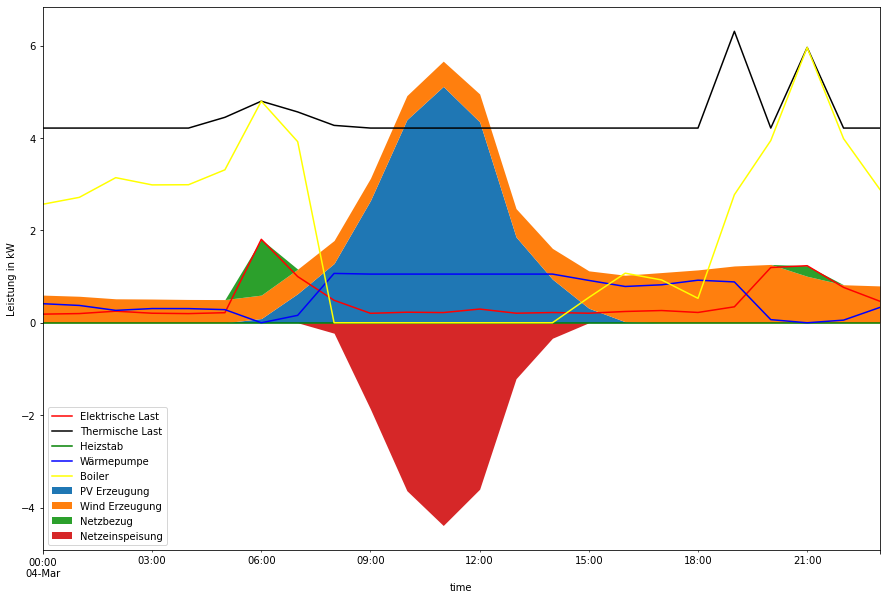

In [29]:
start_time='03-04-18 00:00:00'
end_time='03-04-18 23:00:00'
y='Leistung in kW'
x='Datum'

load_figure = pd.concat([network.loads_t.p_set['electricity_load'],network.loads_t.p_set['thermal_load'], network_4.links_t.p0['heating_rod'],network_4.links_t.p0['heat_pump'],network_4.generators_t.p['boiler'] ], axis = 1)
load_figure.columns = ['Elektrische Last','Thermische Last','Heizstab', 'Wärmepumpe', 'Boiler']
ax = load_figure.loc[start_time:end_time].plot(color = ['red', 'black','green','blue','yellow'], legend = True, stacked = False)
ax.set_xlabel(x)
ax.set_ylabel(y)
df_figure_base = pd.concat([network_4.generators_t.p['pv'], network_4.generators_t.p['wind'], network_4.generators_t.p['grid_import'], -network_4.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc[start_time:end_time].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)
#print(load_figure.loc[start_time:end_time])
#print(df_figure_base.loc[start_time:end_time])

### Interpretation & Schlussfolgerung (HS + WP)

- Durch Wärmepumpe kann tagsüber der Boiler vollständig abgeschaltet werden, wenn genug EE-Strom vorhanden ist
- Heizstab wird kein einziges mal verwendet
    - Grund: Wirkungsgrad der Wärmepumpe viel höher, daher entscheidet sich PyPSA für Wärmepumpe
    - Würden Annuitätskosten mit berücksichtigt werden, so würde eventuell doch der Heizstab verwendet werden (sehr viel geringere Annuitätskosten)
- Die Gesamtkosten erhöhen sich um 607€, da die annuitätischen Kosten der Wärmepumpe nicht durch die Kosteneinsparung (im Gas- und Strombezug) ausgeglichen werden können
- Der Eigenverbrauch erhöht sich um 11,47 Prozentpunkte, da der eigen erzeugte Strom (vorwiegend durch Wind und teilweise durch PV) auch im Wärmesektor verwendet wird

&rarr; Kombination Wärmepumpe und Heizstab nicht sinnvoll, da erhöhte Kosten zu erwarten sind

## Energiemodell Kombination 2 (Heizstab + Thermischer Speicher) <a class="anchor" id="section_3_6"></a>

### Skizze
<img src="Skizzen der Energiesysteme/Skizze des Systems_HSTS.png">

In [30]:
#Netzwerk definieren
network_5 = pypsa.Network()
network_5.set_snapshots(pv_infeed.index)
network_5.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt reprensentiert 1 Stunde.

#Knoten definieren
network_5.add("Bus", name = "electricity")
network_5.add("Bus", name = "electricity_help")
network_5.add("Bus", name = "thermal")

#Lasten definieren
network_5.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)
network_5.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

#Erzeuger definieren
network_5.add("Generator", 
            name = "pv",
            bus = "electricity_help", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
network_5.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
network_5.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], 
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_price"] / heating_boiler["efficiency"])

#Netzanschluss definieren
network_5.add("Generator", 
            name = "grid_import",
            bus = "electricity_help", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
network_5.add("Generator", 
            name = "grid_export",
            bus = "electricity_help", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Negative Kosten = Erlöse
            sign = -1) # Vorzeichen -1 bedeutet, dass Generator Leistung aufnimmt und nicht abgibt.

#Link definieren
network_5.add("Link", 
            name = "link_electricity", 
            bus0 = "electricity_help", 
            bus1 = "electricity",
            p_nom = grid_import["electrical_power"] + pv["electrical_power"])

#--------------------------------------------------------------------------

#Heizstab definieren
network_5.add("Link",
             name = "heating_rod",
             bus0 = "electricity",
             bus1 = "thermal",
             p_nom = heating_rod["electrical_power"],
             efficiency = heating_rod["efficiency"])

#Thermischen Speicher definieren
network_5.add("Bus", name = "storage_thermal")
network_5.add("Link", #Einspeichern
            name = "thermal_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = storage_thermal["power"])
network_5.add("Link", #Ausspeichern
            name = "thermal_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = storage_thermal["power"])
network_5.add("Store", 
            name = "storage_thermal", 
            bus = "storage_thermal", 
            e_nom = storage_thermal["capacity"],
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            standing_loss = storage_thermal["self-discharge"])

In [31]:
# Simulation für den kompletten Zeitraum:
network_5.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 2.21s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.00e+05


('ok', 'optimal')

In [32]:
# Ausführung der Auswertungsfunktion
results_with_modification, results_energy_with_modification = cost_share_evaluation(network_5)

Gesamtkosten=results_with_modification["Gesamtkosten"]+(storage_thermal["annuity_cost"]+heating_rod["annuity_cost"])*100

print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_with_modification["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_with_modification["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_with_modification["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_with_modification["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_modification["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round((Gesamtkosten)/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_with_modification["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2))
      +"€."
     )
a_5=round(results_with_modification["Eigenverbrauchsanteil"]*100,2)
b_5=round((Gesamtkosten)/100,2)
c_5=round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2)
d_5=storage_thermal["annuity_cost"]+heating_rod["annuity_cost"]

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 77.7%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1754.6€ und EEG-Erlöse von 1226.25, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 1149.94€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 8.72 Prozentpunkte und eine Verringerung der Kosten um -12.77€.


<AxesSubplot:xlabel='time', ylabel='Leistung in kW'>

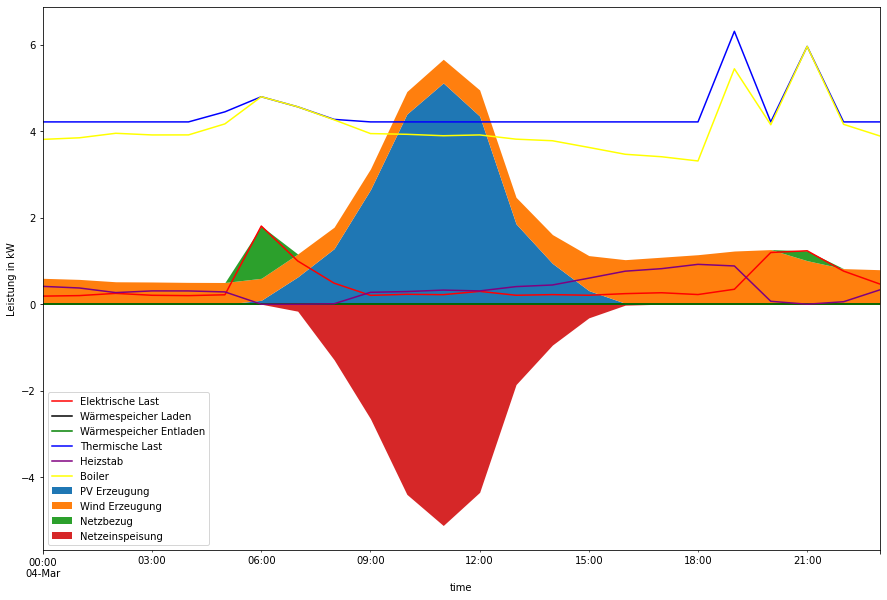

In [33]:
start_time='03-04-18 00:00:00'
end_time='03-04-18 23:00:00'
y='Leistung in kW'
x='Datum'

load_figure = pd.concat([network.loads_t.p_set['electricity_load'], network_5.links_t.p0['thermal_storage_charge'], network_5.links_t.p1['thermal_storage_discharge'],network.loads_t.p_set['thermal_load'], network_5.links_t.p0['heating_rod'], network_5.generators_t.p['boiler']], axis = 1)
load_figure.columns = ['Elektrische Last','Wärmespeicher Laden','Wärmespeicher Entladen','Thermische Last','Heizstab', 'Boiler']
ax = load_figure.loc[start_time:end_time].plot(color = ['red', 'black','green','blue','purple','yellow'], legend = True, stacked = False)
ax.set_xlabel(x)
ax.set_ylabel(y)
df_figure_base = pd.concat([network_5.generators_t.p['pv'], network_5.generators_t.p['wind'], network_5.generators_t.p['grid_import'], -network_5.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc[start_time:end_time].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)
#print(load_figure.loc[start_time:end_time])
#print(df_figure_base.loc[start_time:end_time])

### Interpretation & Schlussfolgerung (HS + TS)

- Die Gesamtkosten erhöhen sich um 12,77€ , 
    - Kosten für Thermischen Speicher (der nicht genutzt wird) übersteigen Nutzen des Heizstabs (durch Nutzen des kostenlosen EE-Stroms)
- Der Eigenverbrauch erhöht sich um 8,72 Prozentpunkte, da der eigen erzeugte Strom (vorwiegend durch Wind und teilweise durch PV) auch im Wärmesektor verwendet wird. Verglichen zum Energiemodell mit Option 1 (Heizstab), erhöht sich der Eigenverbrauch um 0,65 Prozentpunkte
- Lebensdauer-/annuitätskostenveränderte Betriebsweisen des thermischen Speichers für den Erdgaskessel wird in der Simulation   nicht betrachtet

&rarr; Option Heizstab mit thermischen Speicher nicht sinnvoll, da höhere jährliche Gesamtkosten zu erwarten sind. Die Aussagekraft der Simulation ist begrenzt, weil sich die Gesamtkosten verglichen zur Basiskonfiguration minimal um <15€ unterscheiden.(Der Einfluss auf die Annuitätskosten des Erdgaskessels sollte ggf. überprüft werden, um dieses Ergebnis zu validieren.)

## Energiemodell Kombination 3 (Thermischer Speicher + Wärmepumpe) <a class="anchor" id="section_3_7"></a>

### Skizze
<img src="Skizzen der Energiesysteme/Skizze des Systems_WPTS.png">

In [34]:
#Netzwerk definieren
network_6 = pypsa.Network()
network_6.set_snapshots(pv_infeed.index)
network_6.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt reprensentiert 1 Stunde.

#Knoten definieren
network_6.add("Bus", name = "electricity")
network_6.add("Bus", name = "electricity_help")
network_6.add("Bus", name = "thermal")

#Lasten definieren
network_6.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)
network_6.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

#Erzeuger definieren
network_6.add("Generator", 
            name = "pv",
            bus = "electricity_help", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
network_6.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
network_6.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], 
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_price"] / heating_boiler["efficiency"])

#Netzanschluss definieren
network_6.add("Generator", 
            name = "grid_import",
            bus = "electricity_help", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
network_6.add("Generator", 
            name = "grid_export",
            bus = "electricity_help", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Negative Kosten = Erlöse
            sign = -1) # Vorzeichen -1 bedeutet, dass Generator Leistung aufnimmt und nicht abgibt.

#Link definieren
network_6.add("Link", 
            name = "link_electricity", 
            bus0 = "electricity_help", 
            bus1 = "electricity",
            p_nom = grid_import["electrical_power"] + pv["electrical_power"])

#--------------------------------------------------------------------------

#Thermischen Speicher definieren
network_6.add("Bus", name = "storage_thermal")
network_6.add("Link", #Einspeichern
            name = "thermal_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = storage_thermal["power"])
network_6.add("Link", #Ausspeichern
            name = "thermal_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = storage_thermal["power"])
network_6.add("Store", 
            name = "storage_thermal", 
            bus = "storage_thermal", 
            e_nom = storage_thermal["capacity"],
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            standing_loss = storage_thermal["self-discharge"])

#Wärmepumpe definieren
network_6.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=heat_pump["power"],
            efficiency = heat_pump["COP"])

In [35]:
# Simulation für den kompletten Zeitraum:
network_6.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 2.12s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 3.78e+04


('ok', 'optimal')

In [36]:
# Ausführung der Auswertungsfunktion
results_with_modification, results_energy_with_modification = cost_share_evaluation(network_6)

Gesamtkosten=results_with_modification["Gesamtkosten"]+(storage_thermal["annuity_cost"]+heat_pump_annuity_cost)*100

print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_with_modification["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_with_modification["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_with_modification["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_with_modification["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_modification["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round((Gesamtkosten)/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_with_modification["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2))
      +"€."
     )
a_6=round(results_with_modification["Eigenverbrauchsanteil"]*100,2)
b_6=round((Gesamtkosten)/100,2)
c_6=round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2)
d_6=storage_thermal["annuity_cost"]+heat_pump_annuity_cost

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 81.66%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 900.72€ und EEG-Erlöse von 994.78, wobei 0.1kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 1688.37€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 12.68 Prozentpunkte und eine Verringerung der Kosten um -551.2€.


<AxesSubplot:xlabel='time', ylabel='Leistung in kW'>

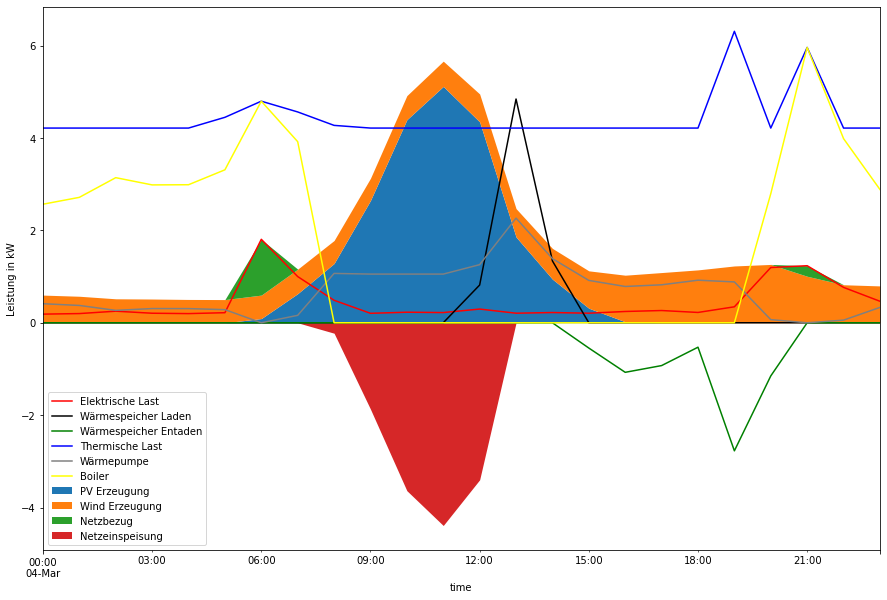

In [37]:
start_time='03-04-18 00:00:00'
end_time='03-04-18 23:00:00'
y='Leistung in kW'
x='Datum'

load_figure = pd.concat([network.loads_t.p_set['electricity_load'], network_6.links_t.p0['thermal_storage_charge'], network_6.links_t.p1['thermal_storage_discharge'],network.loads_t.p_set['thermal_load'], network_6.links_t.p0['heat_pump'], network_6.generators_t.p['boiler']], axis = 1)
load_figure.columns = ['Elektrische Last','Wärmespeicher Laden','Wärmespeicher Entaden','Thermische Last', 'Wärmepumpe','Boiler']
ax = load_figure.loc[start_time:end_time].plot(color = ['red', 'black','green','blue','grey','yellow'], legend = True, stacked = False)
ax.set_xlabel(x)
ax.set_ylabel(y)
df_figure_base = pd.concat([network_6.generators_t.p['pv'], network_6.generators_t.p['wind'], network_6.generators_t.p['grid_import'], -network_6.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc[start_time:end_time].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)
#print(load_figure.loc[start_time:end_time])
#print(df_figure_base.loc[start_time:end_time])

### Interpretation & Schlussfolgerung (TS + WP)

- Durch die Kombination aus Wärmespeicher und Wärmepumpe wird der Boiler weniger genutzt und somit Gaskosten gespart
- Der Eigenverbrauch der PV- und Windkraftanlage kann somit erhöt werden
- Dennoch erhöhen sich die Gesamtkosten um 551€, da die annuitätischen Kosten der Wärmepumpe und des Wärmespeichers die Ersparnisse übersteigen 

&rarr; Investition nicht sinnvoll


## Energiemodell Kombination 4 (Heizstab + Wärmepumpe + Thermischer Speicher) <a class="anchor" id="section_3_8"></a>

### Skizze
<img src="Skizzen der Energiesysteme/Skizze des Systems_WPHSTS.png">

In [38]:
#Netzwerk definieren
network_7 = pypsa.Network()
network_7.set_snapshots(pv_infeed.index)
network_7.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt reprensentiert 1 Stunde.

#Knoten definieren
network_7.add("Bus", name = "electricity")
network_7.add("Bus", name = "electricity_help")
network_7.add("Bus", name = "thermal")

#Lasten definieren
network_7.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)
network_7.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

#Erzeuger definieren
network_7.add("Generator", 
            name = "pv",
            bus = "electricity_help", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
network_7.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
network_7.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], 
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_price"] / heating_boiler["efficiency"])

#Netzanschluss definieren
network_7.add("Generator", 
            name = "grid_import",
            bus = "electricity_help", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
network_7.add("Generator", 
            name = "grid_export",
            bus = "electricity_help", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Negative Kosten = Erlöse
            sign = -1) # Vorzeichen -1 bedeutet, dass Generator Leistung aufnimmt und nicht abgibt.

#Link definieren
network_7.add("Link", 
            name = "link_electricity", 
            bus0 = "electricity_help", 
            bus1 = "electricity",
            p_nom = grid_import["electrical_power"] + pv["electrical_power"])

#--------------------------------------------------------------------------

#Heizstab definieren
network_7.add("Link",
             name = "heating_rod",
             bus0 = "electricity",
             bus1 = "thermal",
             p_nom = heating_rod["electrical_power"],
             efficiency = heating_rod["efficiency"])

#Thermischen Speicher definieren
network_7.add("Bus", name = "storage_thermal")
network_7.add("Link", #Einspeichern
            name = "thermal_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = storage_thermal["power"])
network_7.add("Link", #Ausspeichern
            name = "thermal_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = storage_thermal["power"])
network_7.add("Store", 
            name = "storage_thermal", 
            bus = "storage_thermal", 
            e_nom = storage_thermal["capacity"],
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            standing_loss = storage_thermal["self-discharge"])

#Wärmepumpe definieren
network_7.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=heat_pump["power"],
            efficiency = heat_pump["COP"])

In [39]:
# Simulation für den kompletten Zeitraum:
network_7.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
C:\Users\Mysterioua\anaconda3\lib\site-packages\pypsa\linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 2.25s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 3.78e+04


('ok', 'optimal')

In [40]:
# Ausführung der Auswertungsfunktion
results_with_modification, results_energy_with_modification = cost_share_evaluation(network_7)

Gesamtkosten=results_with_modification["Gesamtkosten"]+(storage_thermal["annuity_cost"]+heat_pump_annuity_cost+heating_rod["annuity_cost"])*100

print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_with_modification["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_with_modification["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_with_modification["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_with_modification["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_modification["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round((Gesamtkosten)/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_with_modification["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2))
      +"€."
     )
a_7=round(results_with_modification["Eigenverbrauchsanteil"]*100,2)
b_7=round((Gesamtkosten)/100,2)
c_7=round((results_base["Gesamtkosten"]-(Gesamtkosten))/100,2)
d_7=round(storage_thermal["annuity_cost"]+heat_pump_annuity_cost+heating_rod["annuity_cost"],2)

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 81.66%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 900.72€ und EEG-Erlöse von 994.78, wobei 0.1kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 1738.37€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 12.68 Prozentpunkte und eine Verringerung der Kosten um -601.2€.


<AxesSubplot:xlabel='time', ylabel='Leistung in kW'>

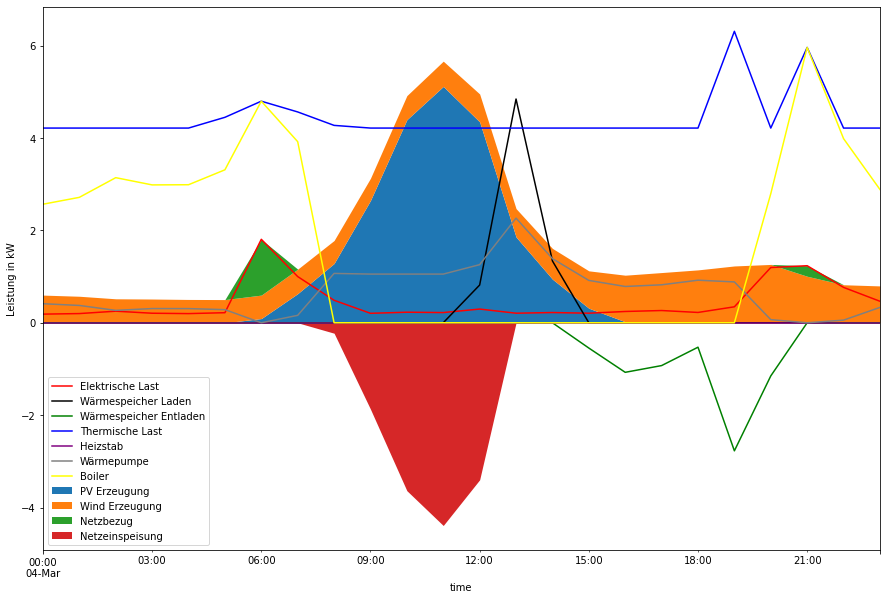

In [41]:
start_time='03-04-18 00:00:00'
end_time='03-04-18 23:00:00'
y='Leistung in kW'
x='Datum'

load_figure = pd.concat([network.loads_t.p_set['electricity_load'], network_7.links_t.p0['thermal_storage_charge'], network_7.links_t.p1['thermal_storage_discharge'],network.loads_t.p_set['thermal_load'],network_7.links_t.p0['heating_rod'],network_7.links_t.p0['heat_pump'], network_7.generators_t.p['boiler']], axis = 1)
load_figure.columns = ['Elektrische Last','Wärmespeicher Laden','Wärmespeicher Entladen','Thermische Last','Heizstab', 'Wärmepumpe','Boiler']
ax = load_figure.loc[start_time:end_time].plot(color = ['red', 'black','green','blue','purple','grey','yellow'], legend = True, stacked = False)
ax.set_xlabel(x)
ax.set_ylabel(y)
df_figure_base = pd.concat([network_7.generators_t.p['pv'], network_7.generators_t.p['wind'], network_7.generators_t.p['grid_import'], -network_7.generators_t.p['grid_export']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc[start_time:end_time].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)
#print(load_figure.loc[start_time:end_time])
#print(df_figure_base.loc[start_time:end_time])

### Interpretation & Schlussfolgerung (HS + WP + TS)

- Durch den Wärmespeicher kann der Zeitraum, in dem der Boiler vollständig abgeschaltet ist, verlängert werden
- Das Laden des Wärmespeichers erfolgt durch die Wärmepumpe (die durch eigen erzeugten Strom gespeist wird)
    - Dadurch Erhöhung Eigenverbrauch um 12,68 Prozentpunkte
- Der Heizstab wird nicht eingesetzt (da Wärmepumpe bessere Effizienz)
- Trotzdem Mehrkosten von 601€, da sehr hohe annuitätische Kosten der Wärmepumpe

&rarr; Kombination Wärmepumpe + Heizstab + Thermischer Speicher nicht sinnvoll, da Heizstab nicht verwendet wird und die Wärmepumpe zu teuer ist

# Vergleich der Optionen und Kombinationen <a class="anchor" id="chapter4"></a>

In [42]:
df = pd.DataFrame(np.array([["Eigenverbrauchsanteil [%]",a_0, a_1, a_2,a_3,a_4,a_5,a_6,a_7],
                            ["Gesamtkosten [€]",b_0,b_1,b_2,b_3,b_4,b_5,b_6,b_7],
                            ["... davon annuitätische Kosten [€]",d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7],
                            ["Verringerung Gesamtkosten [€]",c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7]]),
                   columns=['','Basis','H', 'W', 'TS','H+W','H+TS','TS+W','H+W+TS'])
df

Basis        H         W       TS  \
0           Eigenverbrauchsanteil [%]    68.98    77.05     80.45    68.98   
1                    Gesamtkosten [€]  1137.17  1063.75   1694.39  1237.17   
2  ... davon annuitätische Kosten [€]      0.0     50.0  1210.833    100.0   
3       Verringerung Gesamtkosten [€]      0.0    73.42   -557.22   -100.0   

        H+W     H+TS      TS+W   H+W+TS  
0     80.45     77.7     81.66    81.66  
1   1744.39  1149.94   1688.37  1738.37  
2  1260.833    150.0  1310.833  1360.83  
3   -607.22   -12.77    -551.2   -601.2

<AxesSubplot:xlabel='Option'>

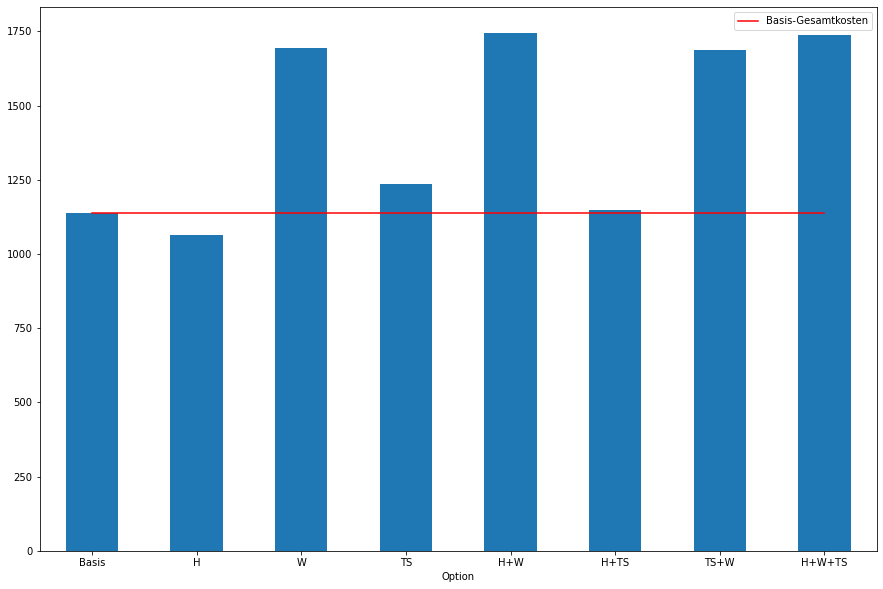

In [43]:
df = pd.DataFrame({'Option':['Basis','H', 'W', 'TS','H+W','H+TS','TS+W','H+W+TS'],
                   'Gesamtkosten [€]':[b_0,b_1,b_2,b_3,b_4,b_5,b_6,b_7],
                   'Verringerung Gesamtkosten [€]':[c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7]})
ax = df.plot.bar(x='Option', y='Gesamtkosten [€]', label="Basis-Gesamtkosten")

ax = pd.Series([b_0,b_0,b_0,b_0,b_0,b_0,b_0,b_0])
ax.plot.line(color='red',figsize=(15,10))

# Grenzen der Modellierung <a class="anchor" id="chapter5"></a>

- Wir bilden nur die Vergangenheit ab
- Statische Energiebezugskosten 
    - Strom und Gas
- Einspeisevergütung PV
    - Unbekannte Anspruchsdauer der Einspeisevergütung
- PV-/Wind- Erzeugungsprofile nur 1 Jahr (Annahme: Zukunft ist genauso)
    - Kein Degradationseffekt berücksichtigt
- Lastprofile (Strom + Wärme) nur 1 Jahr (Annahme: Zukunft ist genauso)
    - Keine zukünftiges verändertes Lastverhalten berücksichtigt (z.B. E-Mobilität)
    - Zweimal diskontinuierliche Änderung des "üblichen" Stromlastverhaltens (evtl. Urlaub)
        - Jährliche Schwankungen der Urlaubszeitpunkte
- Wetterverhältnis des betrachteten Jahres 
    - Was passiert, wenn das Jahr besonders warm/kalt, windreich, sonnenreich etc. war?
- Konstante technische Parameter
    - COP der Wärmepumpe, Wirkungsgrad Boiler
- Kein Unterschied beim Warmwasser- und Heizkreislauf in der Modellierung
- Keine Betriebskosten der Wärmepumpe, PV-Anlage, Windenergieanlage berücksichtigt
- Keine Berücksichtigung der Annuitätskosten der Boiler, PV-Anlage, Windenergieanlage
- Annuitästfaktor ist abhängig von der Lebensdauer
    - Was ist, wenn Lebensdauer kürzer/länger?

**Sind die Ergebnisse trotzdem valide?**

- Ergebnisse sind tendenziell valide, aber wirtschaftliche Ergebnisse bieten eher einen Anhalspunkt, als eine genaue Aussage
    - Berücksichtigung von realen Last- und Erzeugerprofile für ein Jahr
    - Berücksichtigung von technischen Parameter
    - Berücksichtigung von Kostenparameter
- Maßnahmen zur Steigerung der Validität
    - Vergleich des Referensjahres mit anderen Jahren
    - Reale technische Parameter
    - Implementierung dynamische Kostenparameter (Energiebezugskosten etc.)